In [ ]:
# Package installs
%pip install pandas
%pip install matplotlib
%pip install numpy
%pip install seaborn
%pip install scikit-learn
%pip install cartopy
%pip install keras
%pip install keras-tuner
# you may have to install in console using pip install tensorflow --user or pip install tensorflow --upgrade
%pip install tensorflow 

In [ ]:
# Import all packages
# General packages for analysis and visualization
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Modeling tools
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import tensorflow.keras.backend as K
import keras_tuner as kt


# Unused Code ... tokenization appears to be unhelpful for our use case
'''
# Word tokenization tools
pip install nltk
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
import re
'''

In [ ]:
# Get the current working directory
current_directory = os.getcwd()

# Define the path to the dataset
dataset_path = os.path.join(current_directory, 'apartments_for_rent_classified_100K.csv')

# Load the dataset
df = pd.read_csv(dataset_path, delimiter=';', encoding='ISO-8859-1')

# Check the first few rows
df.head()

In [123]:
# check for duplicate data
duplicates_all = df[df.duplicated()]
print("Exact Duplicate Rows:\n", duplicates_all)

#drop duplicates
df = df.drop_duplicates()

Exact Duplicate Rows:
                id                category  \
41958  5508806580  housing/rent/apartment   
41959  5508806428  housing/rent/apartment   
41960  5508806391  housing/rent/apartment   
41961  5508806299  housing/rent/apartment   
41962  5508806233  housing/rent/apartment   
...           ...                     ...   
83243  5197839500  housing/rent/apartment   
83244  5197836604  housing/rent/apartment   
83245  5197834189  housing/rent/apartment   
83246  5197828852  housing/rent/apartment   
83247  5197828778  housing/rent/apartment   

                                                   title  \
41958  Las Vegas, prime location Two BR, Apartment. P...   
41959                          Northglenn Value. Pet OK!   
41960  Apartment in move in condition in District Hei...   
41961  District Heights, prime location Two BR, Apart...   
41962                            Spacious One BR, One BA   
...                                                  ...   
83243  Apartment

In [124]:
# Get basic information about the dataset
df.info()

# Check for missing values
print(df.isnull().sum())

# Check summary statistics
df.describe()

df['has_photo']

<class 'pandas.core.frame.DataFrame'>
Index: 99408 entries, 0 to 99491
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             99408 non-null  int64  
 1   category       99408 non-null  object 
 2   title          99408 non-null  object 
 3   body           99408 non-null  object 
 4   amenities      83374 non-null  object 
 5   bathrooms      99345 non-null  float64
 6   bedrooms       99284 non-null  float64
 7   currency       99408 non-null  object 
 8   fee            99408 non-null  object 
 9   has_photo      99408 non-null  object 
 10  pets_allowed   39034 non-null  object 
 11  price          99407 non-null  float64
 12  price_display  99407 non-null  object 
 13  price_type     99408 non-null  object 
 14  square_feet    99408 non-null  int64  
 15  address        7942 non-null   object 
 16  cityname       99106 non-null  object 
 17  state          99106 non-null  object 
 18  latitude   

0        Thumbnail
1        Thumbnail
2        Thumbnail
3        Thumbnail
4        Thumbnail
           ...    
99487          Yes
99488          Yes
99489          Yes
99490          Yes
99491          Yes
Name: has_photo, Length: 99408, dtype: object

In [125]:
# pets allowed is missing a large number of values and it appears that body does not have enough relevant information that we could hope to impute this value.
# We can either fill the empty values with a place holder or remove it all together. it likely will not be a helpful column...
    # print(df[df['body'].str.contains('Dogs')])
    # print(df[df['body'].str.contains('Cats')])

# For now lets fill it anyways
df.fillna({'pets_allowed':'Unknown'}, inplace=True)
print(df.isnull().sum())

id                   0
category             0
title                0
body                 0
amenities        16034
bathrooms           63
bedrooms           124
currency             0
fee                  0
has_photo            0
pets_allowed         0
price                1
price_display        1
price_type           0
square_feet          0
address          91466
cityname           302
state              302
latitude            25
longitude           25
source               0
time                 0
dtype: int64


In [126]:
# Unused code
'''
# We plan on predicting price, so lets remove nulls from that feature
# Since the number of missing values in latitude, longitude, cityname, state, bathrooms, and bedrooms is so small we will simply drop them (we still retain 99% of the data)
    df = df.dropna(subset = ['price', 'latitude', 'longitude', 'cityname', 'state', 'bathrooms', 'bedrooms'])
# Check for missing values
    print(df.isnull().sum())
    print(df.shape)
'''

"\n# We plan on predicting price, so lets remove nulls from that feature\n# Since the number of missing values in latitude, longitude, cityname, state, bathrooms, and bedrooms is so small we will simply drop them (we still retain 99% of the data)\n    df = df.dropna(subset = ['price', 'latitude', 'longitude', 'cityname', 'state', 'bathrooms', 'bedrooms'])\n# Check for missing values\n    print(df.isnull().sum())\n    print(df.shape)\n"

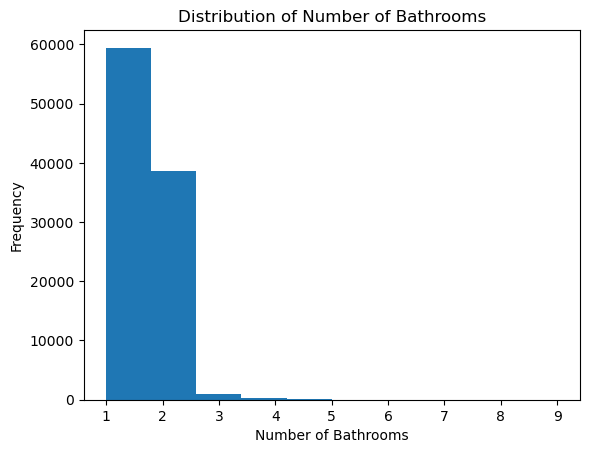

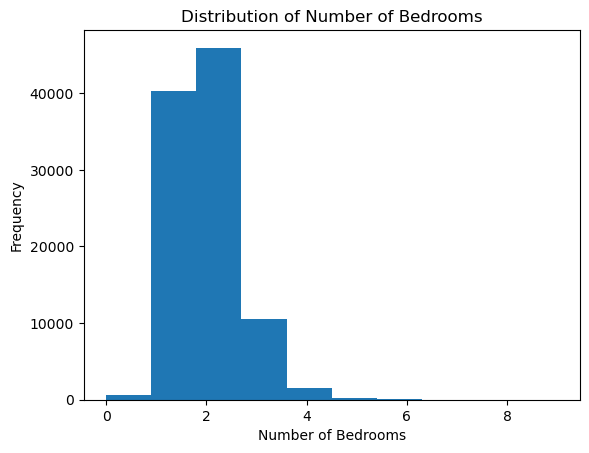

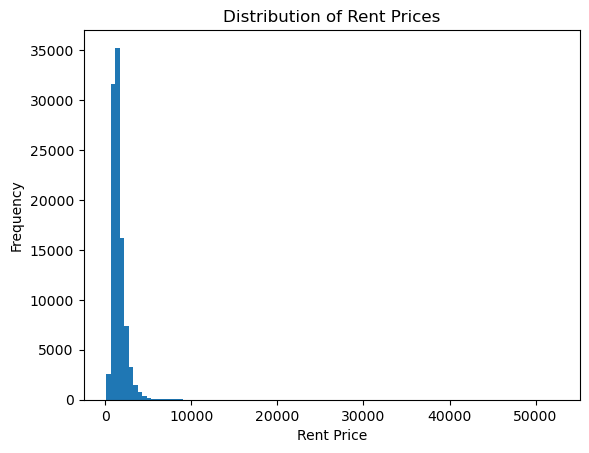

In [127]:
# Alternatively we could impute data. In order to know what would be best; mean, median, or mode we should figure out if data is skewed.
# All of the values are skewed, so intuition suggests that median imuptation is the best here.
plt.figure(1)
plt.hist(df['bathrooms'], bins = 10)
plt.title('Distribution of Number of Bathrooms')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Frequency')
plt.figure(2)
plt.hist(df['bedrooms'], bins = 10)
plt.title('Distribution of Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Frequency')
plt.figure(3)
plt.hist(df['price'], bins = 100)
plt.title('Distribution of Rent Prices')
plt.xlabel('Rent Price')
plt.ylabel('Frequency')
plt.show()

In [128]:
# They can't be seen very well on the graph above, but there are indeed outliers. Otherwise it would not stretch all the way to 50000
df['price'].describe()

count    99407.000000
mean      1527.076403
std        904.372903
min        100.000000
25%       1013.500000
50%       1350.000000
75%       1795.000000
max      52500.000000
Name: price, dtype: float64

In [129]:
# Calculate the median price
median_rent_price = df['price'].median()
# Imput values
df.fillna({'price':median_rent_price}, inplace=True)

# Calculate the median bathroom count
median_bathroom = df['bathrooms'].median()
# Imput values
df.fillna({'bathrooms':median_bathroom}, inplace=True)

# Calculate the median bedroom count
median_bedroom = df['bedrooms'].median()
# Imput values
df.fillna({'bedrooms':median_bedroom}, inplace=True)

# Imputing latitude and longitude does not make sense, so these still have to be removed like before.
# We are also removing null cityname and state rows, since there is no guarantee we can fill them with information from body and title and the population of missing data is so small it is not worth the effort.
df = df.dropna(subset = ['latitude', 'longitude', 'cityname', 'state'])
# Check for missing values
print(df.isnull().sum())
print(df.shape)
# The helpfulness of some of these variables is questionable, but we wont know for sure until we move into week 2

id                   0
category             0
title                0
body                 0
amenities        15899
bathrooms            0
bedrooms             0
currency             0
fee                  0
has_photo            0
pets_allowed         0
price                0
price_display        1
price_type           0
square_feet          0
address          91236
cityname             0
state                0
latitude             0
longitude            0
source               0
time                 0
dtype: int64
(99106, 22)


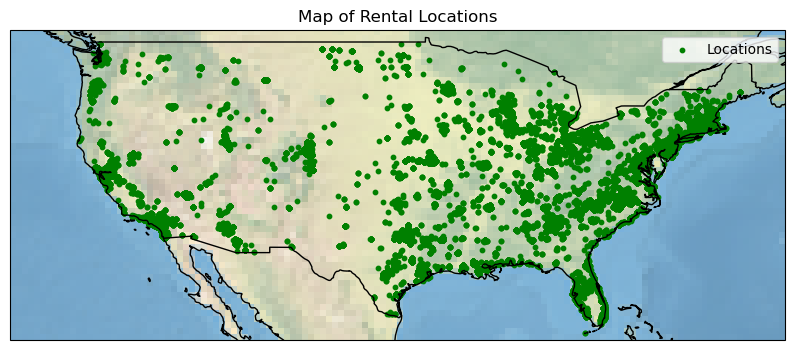

In [130]:
# lets take a look at where all of these rentals are

# Create a plot with Cartopy
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-130, -65, 24, 50], crs=ccrs.PlateCarree())  # Limit to U.S. boundaries

# Add features for land, coastlines, and borders
ax.stock_img()
ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# Plot each point on the map
plt.scatter(df['longitude'], df['latitude'], color='green', s=10, transform=ccrs.PlateCarree(), label='Locations')

plt.title("Map of Rental Locations")
plt.legend()
plt.show()


In [131]:
#Lets convert has photo and pets allowed to numerical variables
# One-hot encode both has photo and pets allowed
# First we will break up pets allowed
# Split the 'pets_allowed' column by comma and expand into separate columns
split_df = df['pets_allowed'].str.split(',', expand=True)

# Create binary columns for 'cats', 'dogs', 'unknown', 'Yes', 'Thumbnail'
df['cats_allowed'] = split_df.apply(lambda x: 1 if 'Cats' in x.values else 0, axis=1)
df['dogs_allowed'] = split_df.apply(lambda x: 1 if 'Dogs' in x.values else 0, axis=1)
df['unknown_allowed'] = split_df.apply(lambda x: 1 if 'Unknown' in x.values else 0, axis=1)
df['has_photo_Thumbnail'] = df.apply(lambda x: 1 if 'Thumbnail' in x.values else 0, axis=1)
df['has_photo_Yes'] = df.apply(lambda x: 1 if 'Yes' in x.values else 0, axis=1)

# Use pandas to create one-hot encoded columns
df = pd.get_dummies(df, columns=['category'], prefix='category')
# Convert only boolean columns to integers
boolean_columns = df.select_dtypes(include='bool').columns
df[boolean_columns] = df[boolean_columns].astype(int)
print(df.dtypes) 

id                                           int64
title                                       object
body                                        object
amenities                                   object
bathrooms                                  float64
bedrooms                                   float64
currency                                    object
fee                                         object
has_photo                                   object
pets_allowed                                object
price                                      float64
price_display                               object
price_type                                  object
square_feet                                  int64
address                                     object
cityname                                    object
state                                       object
latitude                                   float64
longitude                                  float64
source                         

In [132]:
# Tokenizing ended up not being helpful
'''
# Since there is not a lot in the way of feature engineering that needs to be done we will take the time to extract certain keywords using the Bag of words to get frequency counts, but first comes extracting the words.
# Download the stopwords list from NLTK (removes words like: "is, the, a, and, but, ...")
#nltk.download('stopwords')

# Get the English stopwords
stop_words = set(stopwords.words('english'))

# Function to extract words and remove stopwords
def extract_words(text):
    # Remove non-alphabetical characters, convert to lowercase, and split into words
    words = re.findall(r'\b[a-zA-Z]+\b', str(text).lower())
    # Filter out the stopwords
    filtered_words = [word for word in words if word not in stop_words]
    return filtered_words

# Apply the function to the 'title' and 'body' columns
df['title_words_filtered'] = df['title'].apply(extract_words)
df['body_words_filtered'] = df['body'].apply(extract_words)

# Display the extracted words
df[['title_words_filtered', 'body_words_filtered']]
'''

'\n# Since there is not a lot in the way of feature engineering that needs to be done we will take the time to extract certain keywords using the Bag of words to get frequency counts, but first comes extracting the words.\n# Download the stopwords list from NLTK (removes words like: "is, the, a, and, but, ...")\n#nltk.download(\'stopwords\')\n\n# Get the English stopwords\nstop_words = set(stopwords.words(\'english\'))\n\n# Function to extract words and remove stopwords\ndef extract_words(text):\n    # Remove non-alphabetical characters, convert to lowercase, and split into words\n    words = re.findall(r\'\x08[a-zA-Z]+\x08\', str(text).lower())\n    # Filter out the stopwords\n    filtered_words = [word for word in words if word not in stop_words]\n    return filtered_words\n\n# Apply the function to the \'title\' and \'body\' columns\ndf[\'title_words_filtered\'] = df[\'title\'].apply(extract_words)\ndf[\'body_words_filtered\'] = df[\'body\'].apply(extract_words)\n\n# Display the ext

In [133]:
# More unused tokenizing code
'''
# Now lets take a look at the most frequently occuring words

# Combine 'title_words_filtered' and 'body_words_filtered' into a single column of text
df['text'] = df['title_words_filtered'].apply(lambda x: ' '.join(x)) + ' ' + df['body_words_filtered'].apply(lambda x: ' '.join(x))

# determine the top 100 most frequent words
max_features = 20
count_vectorizer = CountVectorizer(max_features=max_features)

# Fit and transform the text data
X_count = count_vectorizer.fit_transform(df['text'])

# Get the list of top words (features)
top_words = count_vectorizer.get_feature_names_out()

# Step 2: Convert the sparse matrix to a DataFrame
X_count_df = pd.DataFrame(X_count.toarray(), columns=top_words)

X_count_df.columns = [col + '_word' for col in X_count_df.columns]

# Display the first 5 rows showing the frequency of top words for each entry
X_count_df.head()
'''

"\n# Now lets take a look at the most frequently occuring words\n\n# Combine 'title_words_filtered' and 'body_words_filtered' into a single column of text\ndf['text'] = df['title_words_filtered'].apply(lambda x: ' '.join(x)) + ' ' + df['body_words_filtered'].apply(lambda x: ' '.join(x))\n\n# determine the top 100 most frequent words\nmax_features = 20\ncount_vectorizer = CountVectorizer(max_features=max_features)\n\n# Fit and transform the text data\nX_count = count_vectorizer.fit_transform(df['text'])\n\n# Get the list of top words (features)\ntop_words = count_vectorizer.get_feature_names_out()\n\n# Step 2: Convert the sparse matrix to a DataFrame\nX_count_df = pd.DataFrame(X_count.toarray(), columns=top_words)\n\nX_count_df.columns = [col + '_word' for col in X_count_df.columns]\n\n# Display the first 5 rows showing the frequency of top words for each entry\nX_count_df.head()\n"

In [134]:
# This is where we discovered that tokenization is not useful, at least using the technique we tried...
'''
# Combine the two DataFrames
df2 = pd.concat([df.reset_index(drop=True), X_count_df.reset_index(drop=True)], axis=1)

# Calculate the correlation matrix for all numerical columns
correlation_matrix = df2.select_dtypes(include='number').corr()

# Display the correlation matrix
# unfortunately the extracted words appear to be a dead end
correlation_matrix
'''

"\n# Combine the two DataFrames\ndf2 = pd.concat([df.reset_index(drop=True), X_count_df.reset_index(drop=True)], axis=1)\n\n# Calculate the correlation matrix for all numerical columns\ncorrelation_matrix = df2.select_dtypes(include='number').corr()\n\n# Display the correlation matrix\n# unfortunately the extracted words appear to be a dead end\ncorrelation_matrix\n"

In [135]:
# Check Correlations
df.select_dtypes(include='number').corr()

,id,bathrooms,bedrooms,price,square_feet,latitude,longitude,time,cats_allowed,dogs_allowed,unknown_allowed,has_photo_Thumbnail,has_photo_Yes,category_housing/rent,category_housing/rent/apartment,category_housing/rent/commercial/retail,category_housing/rent/condo,category_housing/rent/home,category_housing/rent/other,category_housing/rent/short_term
id,1.000000,-0.046243,0.003397,0.057745,-0.009748,0.195803,0.022373,0.997911,0.036262,0.026701,-0.040477,0.126382,-0.135004,-0.006255,-0.015330,0.016791,0.002001,0.006160,0.000914,0.005374
bathrooms,-0.046243,1.000000,0.678983,0.328982,0.674493,-0.091164,-0.011976,-0.044548,-0.011423,0.005677,0.008644,-0.010127,0.008558,0.006329,-0.001001,-0.000624,0.002228,-0.002266,-0.002585,-0.000815
bedrooms,0.003397,0.678983,1.000000,0.237929,0.660548,0.012749,0.038188,0.003079,-0.027428,-0.016773,0.024150,-0.006670,0.005590,0.012667,0.000244,-0.006289,-0.000456,0.002302,0.005394,-0.001940
price,0.057745,0.328982,0.237929,1.000000,0.399908,0.055670,-0.105781,0.056189,-0.056152,-0.049547,0.054587,-0.052121,0.032868,0.004460,-0.004933,0.005579,0.002798,-0.002728,-0.000881,-0.003972
square_feet,-0.009748,0.674493,0.660548,0.399908,1.000000,-0.032965,0.063245,-0.009789,-0.044200,-0.027694,0.039999,-0.014730,0.010735,0.019224,-0.006312,0.001154,-0.001684,-0.001802,0.001180,-0.001856
latitude,0.195803,-0.091164,0.012749,0.055670,-0.032965,1.000000,0.080311,0.198051,-0.006319,-0.029261,0.005371,-0.007515,-0.002482,0.002518,-0.008842,0.009470,0.004889,-0.003963,0.005518,-0.002525
longitude,0.022373,-0.011976,0.038188,-0.105781,0.063245,0.080311,1.000000,0.022378,0.002496,0.001010,-0.000862,-0.029032,0.041251,-0.000621,-0.014173,0.018178,-0.001574,-0.000225,-0.000310,-0.000994
time,0.997911,-0.044548,0.003079,0.056189,-0.009789,0.198051,0.022378,1.000000,0.032069,0.022876,-0.036074,0.138037,-0.152516,-0.006195,-0.015256,0.016949,0.001865,0.005748,0.000797,0.005081
cats_allowed,0.036262,-0.011423,-0.027428,-0.056152,-0.044200,-0.006319,0.002496,0.032069,1.000000,0.958751,-0.997336,0.094823,-0.050257,-0.001818,0.014895,-0.015504,-0.004411,0.001415,-0.002547,-0.001839
dogs_allowed,0.026701,0.005677,-0.016773,-0.049547,-0.027694,-0.029261,0.001010,0.022876,0.958751,1.000000,-0.961566,0.088953,-0.045046,-0.001534,0.014139,-0.014903,-0.004253,0.001654,-0.002455,-0.001629


In [136]:
# Triple checking there are no duplicates, since I made a mistake earlier that made duplicate columns. It appears to be corrected now...
# Check for duplicate columns by comparing column names
duplicate_columns = df.columns[df.columns.duplicated()]

# Print out the duplicate columns, if any
if len(duplicate_columns) > 0:
    print(f"Duplicate columns found: {duplicate_columns}")
else:
    print("No duplicate columns found.")

No duplicate columns found.


In [137]:
# It might be worthwhile to convert the unix timestamp to actual dates, but since we are using it to predict a continuous feature and the correlation isnt really there based on prior observations. 
# Convert Unix timestamp to datetime
df['datetime'] = pd.to_datetime(df['time'], unit='s')

# Extract time-based features
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['day_of_week'] = df['datetime'].dt.dayofweek
df['hour'] = df['datetime'].dt.hour

df.describe()

,id,bathrooms,bedrooms,price,square_feet,latitude,longitude,time,cats_allowed,dogs_allowed,...,category_housing/rent/condo,category_housing/rent/home,category_housing/rent/other,category_housing/rent/short_term,datetime,year,month,day,day_of_week,hour
count,9.910600e+04,99106.000000,99106.000000,99106.000000,99106.000000,99106.000000,99106.000000,9.910600e+04,99106.000000,99106.000000,...,99106.000000,99106.000000,99106.000000,99106.000000,99106,99106.000000,99106.000000,99106.000000,99106.000000,99106.000000
mean,5.358117e+09,1.445145,1.728674,1525.505923,955.993209,36.941223,-91.555450,1.559652e+09,0.391288,0.374034,...,0.000030,0.000040,0.000010,0.000040,2019-06-04 12:42:46.529261568,2018.838002,7.458993,17.782768,2.952253,12.272627
min,5.121046e+09,1.000000,0.000000,100.000000,101.000000,19.573800,-159.369800,1.544174e+09,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2018-12-07 09:20:18,2018.000000,1.000000,1.000000,0.000000,0.000000
25%,5.197948e+09,1.000000,1.000000,1012.000000,729.000000,33.743525,-104.817100,1.550832e+09,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2019-02-22 10:33:41,2019.000000,2.000000,17.000000,2.000000,6.000000
50%,5.508672e+09,1.000000,2.000000,1350.000000,900.000000,37.213900,-84.549400,1.568745e+09,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2019-09-17 18:29:48,2019.000000,9.000000,18.000000,3.000000,13.000000
75%,5.509007e+09,2.000000,2.000000,1795.000000,1115.000000,39.955900,-77.576700,1.568767e+09,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,2019-09-18 00:35:46,2019.000000,9.000000,22.000000,4.000000,19.000000
max,5.669439e+09,9.000000,9.000000,52500.000000,40000.000000,64.833200,-68.778800,1.577391e+09,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,2019-12-26 20:17:05,2019.000000,12.000000,31.000000,6.000000,23.000000
std,1.846996e+08,0.547073,0.748731,903.656481,387.731210,4.604615,15.832494,1.105034e+07,0.488041,0.483875,...,0.005502,0.006353,0.003177,0.006353,NaN,0.368451,3.921028,5.244095,1.464940,7.112326


In [138]:
df.select_dtypes(include='number').columns 

Index(['id', 'bathrooms', 'bedrooms', 'price', 'square_feet', 'latitude',
       'longitude', 'time', 'cats_allowed', 'dogs_allowed', 'unknown_allowed',
       'has_photo_Thumbnail', 'has_photo_Yes', 'category_housing/rent',
       'category_housing/rent/apartment',
       'category_housing/rent/commercial/retail',
       'category_housing/rent/condo', 'category_housing/rent/home',
       'category_housing/rent/other', 'category_housing/rent/short_term',
       'year', 'month', 'day', 'day_of_week', 'hour'],
      dtype='object')

In [139]:
# There isn't a great way to make use of the amenities column and trying to dig out a few thousand addresses from the body column to put in address does not seem worthwhile when a majority of it is empty, So we will drop these columns.
# We will drop body and title, since we have already extracted what we can from them. id and currency dont provide any value to what we are trying to accomplish.
df = df.drop(columns = ['amenities', 'address', 'body', 'title', 'id', 'currency', 'price_display', 'source', 'has_photo', 'time'])

In [140]:
'''
# Lets clip off those outliers to prevent distortion.
# Define upper and lower percentiles to clip outliers
lower_bound = df['price'].quantile(0.01)
upper_bound = df['price'].quantile(0.99)

# Clip values outside these bounds
df['price_clipped'] = df['price'].clip(lower=lower_bound, upper=upper_bound)
df['price_clipped'].describe()
'''

"\n# Lets clip off those outliers to prevent distortion.\n# Define upper and lower percentiles to clip outliers\nlower_bound = df['price'].quantile(0.01)\nupper_bound = df['price'].quantile(0.99)\n\n# Clip values outside these bounds\ndf['price_clipped'] = df['price'].clip(lower=lower_bound, upper=upper_bound)\ndf['price_clipped'].describe()\n"

In [141]:
# The data is highly skewed so lets apply a log transform to correct that. 
# We cant scale longitude due to negative values, so we will leave out coordinates.

def log_transform_and_min_max_normalize(df, column):
    # Log transformation with a small constant to avoid log(0)
    df[column] = np.log1p(df[column])
    
    # Min-max normalization to [0, 1] after log transformation
    min_val = df[column].min()
    max_val = df[column].max()
    df[column] = (df[column] - min_val) / (max_val - min_val)

# Apply log transformation and min-max normalization to each numeric column
numeric_columns = [
    'price', 'bathrooms', 'bedrooms', 'square_feet', 'cats_allowed', 'dogs_allowed', 'category_housing/rent',
    'category_housing/rent/apartment', 'category_housing/rent/commercial/retail',
    'category_housing/rent/condo', 'category_housing/rent/home',
    'category_housing/rent/other', 'category_housing/rent/short_term',
    'unknown_allowed', 'has_photo_Thumbnail', 'has_photo_Yes', 'year',
    'month', 'day', 'day_of_week', 'hour'
]

# Apply transformations to each numeric column
for col in numeric_columns:
    log_transform_and_min_max_normalize(df, col)

df.describe()


,bathrooms,bedrooms,price,square_feet,latitude,longitude,cats_allowed,dogs_allowed,unknown_allowed,has_photo_Thumbnail,...,category_housing/rent/condo,category_housing/rent/home,category_housing/rent/other,category_housing/rent/short_term,datetime,year,month,day,day_of_week,hour
count,99106.000000,99106.000000,99106.000000,99106.000000,99106.000000,99106.000000,99106.000000,99106.000000,99106.000000,99106.000000,...,99106.000000,99106.000000,99106.000000,99106.000000,99106,99106.000000,99106.000000,99106.000000,99106.000000,99106.000000
mean,0.110482,0.420266,0.417493,0.365116,36.941223,-91.555450,0.391288,0.374034,0.607441,0.344803,...,0.000030,0.000040,0.000010,0.000040,2019-06-04 12:42:46.529261568,0.838002,0.686984,0.788834,0.665692,0.733789
min,0.000000,0.000000,0.000000,0.000000,19.573800,-159.369800,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2018-12-07 09:20:18,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.301030,0.368684,0.329567,33.743525,-104.817100,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2019-02-22 10:33:41,1.000000,0.216618,0.792481,0.564575,0.612296
50%,0.000000,0.477121,0.414727,0.364810,37.213900,-84.549400,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2019-09-17 18:29:48,1.000000,0.859833,0.811982,0.712414,0.830400
75%,0.251930,0.477121,0.460256,0.400646,39.955900,-77.576700,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,2019-09-18 00:35:46,1.000000,0.859833,0.880890,0.827087,0.942631
max,1.000000,1.000000,1.000000,1.000000,64.833200,-68.778800,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,2019-12-26 20:17:05,1.000000,1.000000,1.000000,1.000000,1.000000
std,0.131353,0.116560,0.070108,0.056202,4.604615,15.832494,0.488041,0.483875,0.488323,0.475306,...,0.005502,0.006353,0.003177,0.006353,NaN,0.368451,0.326426,0.127132,0.211739,0.267077


In [142]:
# Set up data
X = df[['bathrooms', 'bedrooms', 'square_feet', 'latitude',
       'longitude', 'cats_allowed', 'dogs_allowed', 'unknown_allowed', 
       'category_housing/rent', 'category_housing/rent/apartment', 
       'category_housing/rent/commercial/retail',
       'category_housing/rent/condo', 'category_housing/rent/home',
       'category_housing/rent/other', 'category_housing/rent/short_term',
       'has_photo_Thumbnail', 'has_photo_Yes', 'year',
       'month', 'day', 'day_of_week', 'hour']]

y = df['price']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
# Save the test data and train data
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)


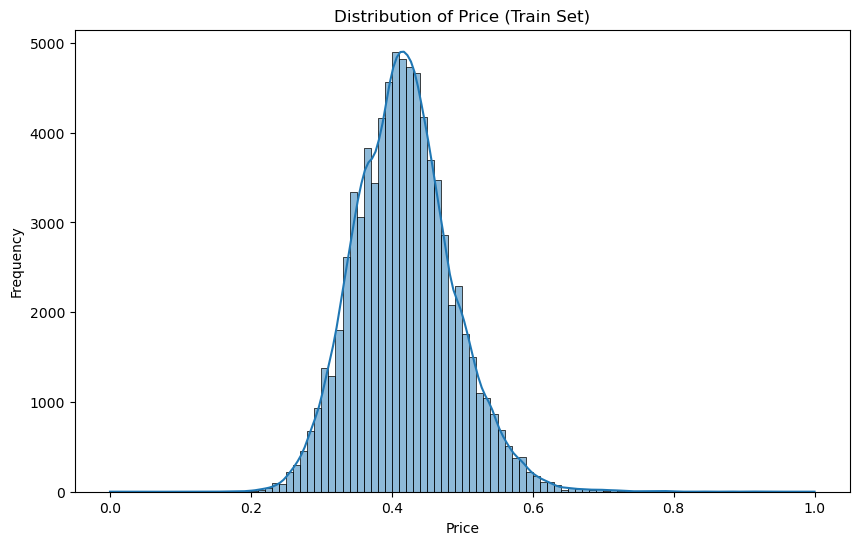

In [143]:
# Are the datasets balanced?
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=100, kde=True)
plt.title('Distribution of Price (Train Set)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


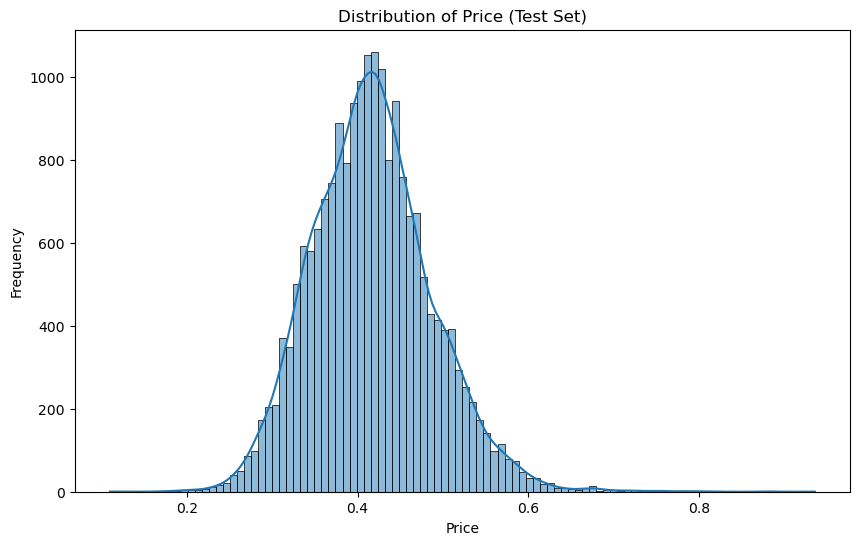

In [144]:
# They appear to be balanced
plt.figure(figsize=(10, 6))
sns.histplot(y_test, bins=100, kde=True)
plt.title('Distribution of Price (Test Set)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [145]:
# Set up models and initialize dictionaries
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),  
    "Lasso Regression": Lasso()   
}

results = {}
predictions_dict = {}

# mean squared error is deprecated and the new version of rmse doesn't seem to work on my version, so we are just calculating it manually.
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    # Calculate MAE
    mae = mean_absolute_error(y_test, predictions)

    # Manually calculate RMSE
    rmse = np.sqrt(np.mean((y_test - predictions) ** 2))

    # Calculate R²
    r2 = r2_score(y_test, predictions)

    # Store the results
    results[name] = {"MAE": mae, "RMSE": rmse, "R²": r2}
    predictions_dict[name] = predictions

results

{'Linear Regression': {'MAE': 0.048880843782789556,
  'RMSE': 0.06205799366025573,
  'R²': 0.21778492098891888},
 'Ridge Regression': {'MAE': 0.048878443467908844,
  'RMSE': 0.062053631945486916,
  'R²': 0.21789487230906313},
 'Lasso Regression': {'MAE': 0.05477103143222919,
  'RMSE': 0.07017309175679602,
  'R²': -0.00016567412294588024}}

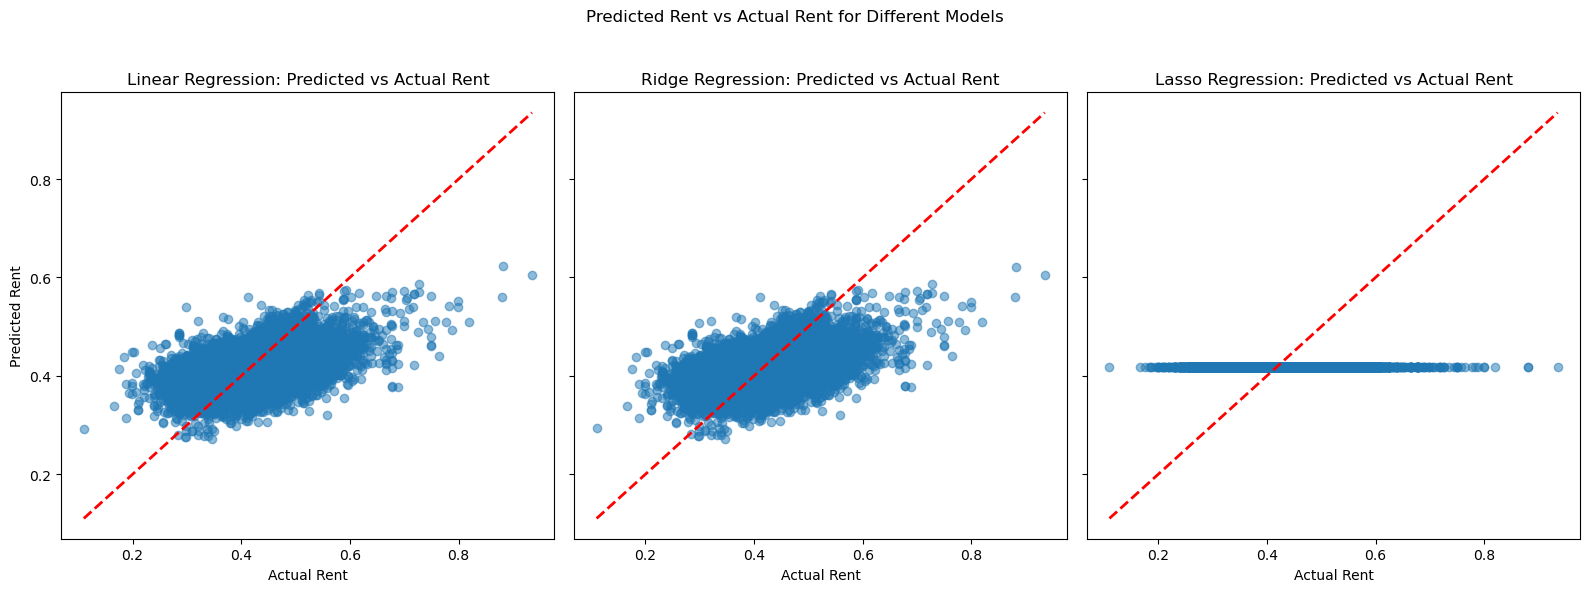

In [146]:
# Set up subplots for each model
num_models = len(predictions_dict)
fig, axes = plt.subplots(1, num_models, figsize=(16, 6), sharey=True)

for i, (name, predictions) in enumerate(predictions_dict.items()):
    axes[i].scatter(y_test, predictions, alpha=0.5)
    # Plot a reference line for perfect predictions
    axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
    axes[i].set_xlabel('Actual Rent')
    axes[i].set_title(f'{name}: Predicted vs Actual Rent')

# Set the common y-label and main title
axes[0].set_ylabel('Predicted Rent')
fig.suptitle('Predicted Rent vs Actual Rent for Different Models')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [147]:
# Some of the prediction values seemed a little funky so we are double checking everything is unique
# Check if y_train and y_test have the same values
if np.array_equal(y_train.values, y_test.values):
    print("y_train and y_test have the same values.")
else:
    print("y_train and y_test are different.")

# Check unique values in y_train and y_test
print("Unique values in y_train:", y_train.unique())
print("Unique values in y_test:", y_test.unique())

y_train and y_test are different.
Unique values in y_train: [0.43102964 0.40684174 0.44336825 ... 0.56708615 0.58786196 0.54676653]
Unique values in y_test: [0.42887737 0.55266911 0.42437253 ... 0.31933015 0.51010848 0.5370428 ]


In [148]:
# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso()
}

# Initialize K-Folds
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize results storage
results = {}

for name, model in models.items():
    print(f"\nEvaluating {name} with K-Fold Cross-Validation")
    
    mae_scores = []
    rmse_scores = []
    r2_scores = []
    
    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Fit the model and make predictions
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, predictions)
        
        # Calculate RMSE manually
        rmse = np.sqrt(np.mean((y_test - predictions) ** 2))
        
        # Calculate R²
        r2 = r2_score(y_test, predictions)

        # Append scores to lists
        mae_scores.append(mae)
        rmse_scores.append(rmse)
        r2_scores.append(r2)
        
        print(f"Model: {name}, Fold: {fold}, MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")
    
    # Store mean and standard deviation of each metric for each model
    results[name] = {
        "Mean MAE": np.mean(mae_scores),
        "Std MAE": np.std(mae_scores),
        "Mean RMSE": np.mean(rmse_scores),
        "Std RMSE": np.std(rmse_scores),
        "Mean R²": np.mean(r2_scores),
        "Std R²": np.std(r2_scores)
    }

results


Evaluating Linear Regression with K-Fold Cross-Validation
Model: Linear Regression, Fold: 1, MAE: 0.05, RMSE: 0.06, R²: 0.22
Model: Linear Regression, Fold: 2, MAE: 0.05, RMSE: 0.06, R²: 0.21
Model: Linear Regression, Fold: 3, MAE: 0.05, RMSE: 0.06, R²: 0.22
Model: Linear Regression, Fold: 4, MAE: 0.05, RMSE: 0.06, R²: 0.21
Model: Linear Regression, Fold: 5, MAE: 0.05, RMSE: 0.06, R²: 0.22

Evaluating Ridge Regression with K-Fold Cross-Validation
Model: Ridge Regression, Fold: 1, MAE: 0.05, RMSE: 0.06, R²: 0.22
Model: Ridge Regression, Fold: 2, MAE: 0.05, RMSE: 0.06, R²: 0.21
Model: Ridge Regression, Fold: 3, MAE: 0.05, RMSE: 0.06, R²: 0.22
Model: Ridge Regression, Fold: 4, MAE: 0.05, RMSE: 0.06, R²: 0.21
Model: Ridge Regression, Fold: 5, MAE: 0.05, RMSE: 0.06, R²: 0.22

Evaluating Lasso Regression with K-Fold Cross-Validation
Model: Lasso Regression, Fold: 1, MAE: 0.05, RMSE: 0.07, R²: -0.00
Model: Lasso Regression, Fold: 2, MAE: 0.05, RMSE: 0.07, R²: -0.00
Model: Lasso Regression, F

{'Linear Regression': {'Mean MAE': 0.04898169218527957,
  'Std MAE': 0.0002604994819939327,
  'Mean RMSE': 0.06209428898347048,
  'Std RMSE': 0.00041538094950223045,
  'Mean R²': 0.2154763000893034,
  'Std R²': 0.005715078365348613},
 'Ridge Regression': {'Mean MAE': 0.04897725299259447,
  'Std MAE': 0.0002592640948510338,
  'Mean RMSE': 0.06208914251599611,
  'Std RMSE': 0.0004156127212588142,
  'Mean R²': 0.2156060643055815,
  'Std R²': 0.0057576272633173805},
 'Lasso Regression': {'Mean MAE': 0.05468150737047872,
  'Std MAE': 0.00025923041571445624,
  'Mean RMSE': 0.07010727691144511,
  'Std RMSE': 0.0003364468984575103,
  'Mean R²': -6.170771614808502e-05,
  'Std R²': 8.28640677871455e-05}}

Top features for Linear Regression:

                                    Feature  Importance
2                               square_feet    0.491225
0                                 bathrooms    0.082320
1                                  bedrooms   -0.080683
10  category_housing/rent/commercial/retail    0.043185
20                              day_of_week   -0.040640
12               category_housing/rent/home   -0.035291
14         category_housing/rent/short_term   -0.034436
11              category_housing/rent/condo   -0.017743
9           category_housing/rent/apartment    0.017537
8                     category_housing/rent    0.015831
13              category_housing/rent/other    0.010917
17                                     year   -0.010495
15                      has_photo_Thumbnail   -0.007663
5                              cats_allowed   -0.005482
16                            has_photo_Yes   -0.004723
6                              dogs_allowed    0.003142
3          

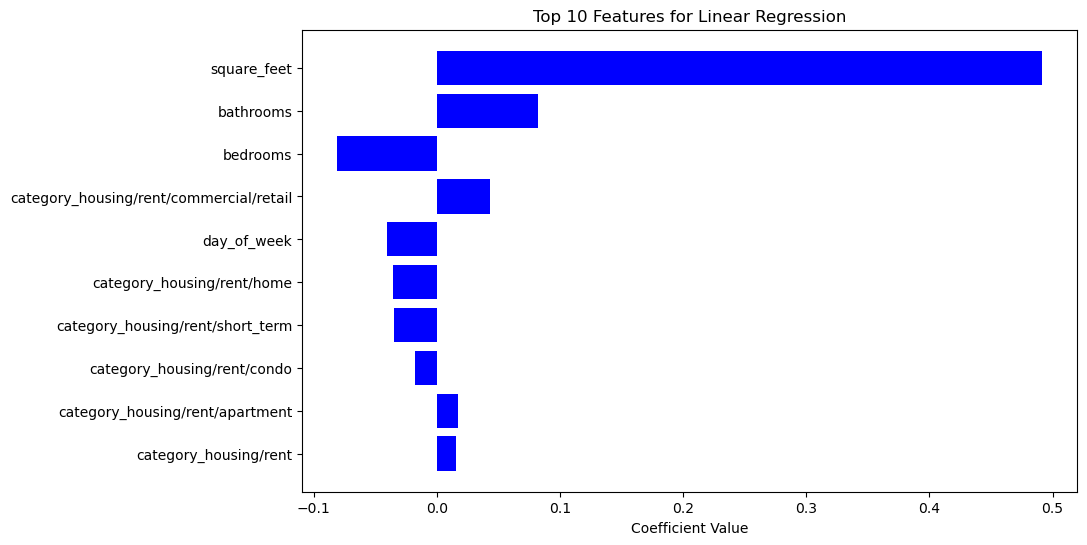

Top features for Ridge Regression:

                                    Feature  Importance
2                               square_feet    0.486379
0                                 bathrooms    0.083081
1                                  bedrooms   -0.079587
20                              day_of_week   -0.040638
10  category_housing/rent/commercial/retail    0.039582
12               category_housing/rent/home   -0.028462
14         category_housing/rent/short_term   -0.027819
9           category_housing/rent/apartment    0.014901
11              category_housing/rent/condo   -0.013585
8                     category_housing/rent    0.011240
17                                     year   -0.010460
15                      has_photo_Thumbnail   -0.007670
5                              cats_allowed   -0.005619
16                            has_photo_Yes   -0.004720
13              category_housing/rent/other    0.004141
6                              dogs_allowed    0.003177
3           

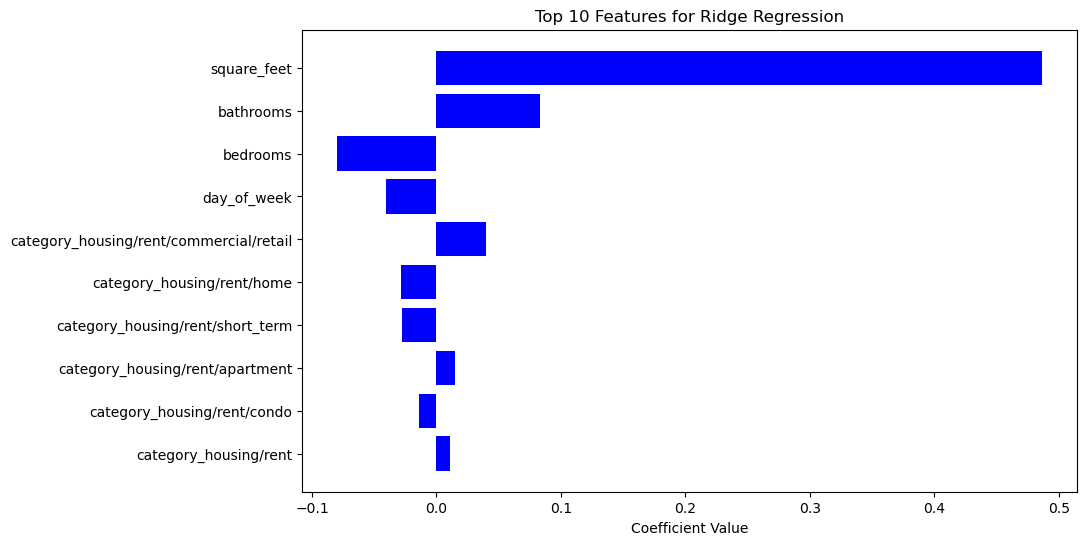

Top features for Lasso Regression:

                                    Feature  Importance
0                                 bathrooms         0.0
1                                  bedrooms         0.0
20                              day_of_week        -0.0
19                                      day        -0.0
18                                    month         0.0
17                                     year         0.0
16                            has_photo_Yes         0.0
15                      has_photo_Thumbnail        -0.0
14         category_housing/rent/short_term        -0.0
13              category_housing/rent/other        -0.0
12               category_housing/rent/home        -0.0
11              category_housing/rent/condo        -0.0
10  category_housing/rent/commercial/retail         0.0
9           category_housing/rent/apartment        -0.0
8                     category_housing/rent         0.0
7                           unknown_allowed         0.0
6           

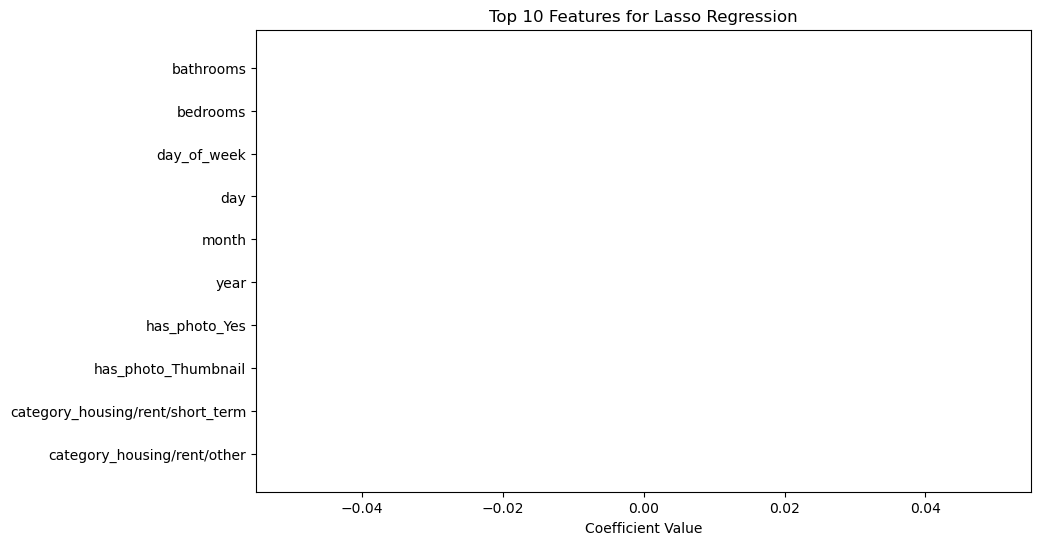

In [149]:
# Extract feature names
feature_names = X.columns

# Dictionary to store feature importances for each model
feature_importances = {}

for model_name, model in models.items():
    # Extract coefficients
    coefs = model.coef_
    
    # Create a DataFrame for easy viewing
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': coefs
    })
    
    # Sort by absolute value of coefficients to identify top features
    importance_df['Abs_Importance'] = importance_df['Importance'].abs()
    importance_df = importance_df.sort_values(by='Abs_Importance', ascending=False)
    
    # Store sorted DataFrame for each model
    feature_importances[model_name] = importance_df

    # Display feature importance
    print(f"Top features for {model_name}:\n")
    print(importance_df[['Feature', 'Importance']], "\n")

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color='b')
    plt.xlabel("Coefficient Value")
    plt.title(f"Top 10 Features for {model_name}")
    plt.gca().invert_yaxis()
    plt.show()

# results indicate that day, month, hour are our most likely candidate to be removed from future modeling. removing these does not change model performance negatively or positively for regression purposes.

# Model evaluation prior to log transformation

Evaluating Linear Regression with K-Fold Cross-Validation\
Model: Linear Regression, Fold: 1, MAE: 467.79, RMSE: 625.20, R²: 0.20\
Model: Linear Regression, Fold: 2, MAE: 464.01, RMSE: 620.01, R²: 0.19\
Model: Linear Regression, Fold: 3, MAE: 468.26, RMSE: 624.33, R²: 0.21\
Model: Linear Regression, Fold: 4, MAE: 472.57, RMSE: 639.49, R²: 0.19\
Model: Linear Regression, Fold: 5, MAE: 464.44, RMSE: 637.52, R²: 0.16

Evaluating Ridge Regression with K-Fold Cross-Validation\
Model: Ridge Regression, Fold: 1, MAE: 467.79, RMSE: 625.20, R²: 0.20\
Model: Ridge Regression, Fold: 2, MAE: 464.00, RMSE: 619.98, R²: 0.19\
Model: Ridge Regression, Fold: 3, MAE: 468.15, RMSE: 624.06, R²: 0.21\
Model: Ridge Regression, Fold: 4, MAE: 472.55, RMSE: 639.47, R²: 0.19\
Model: Ridge Regression, Fold: 5, MAE: 464.43, RMSE: 637.51, R²: 0.16

Evaluating Lasso Regression with K-Fold Cross-Validation\
Model: Lasso Regression, Fold: 1, MAE: 467.98, RMSE: 625.30, R²: 0.20\
Model: Lasso Regression, Fold: 2, MAE: 464.09, RMSE: 619.96, R²: 0.19\
Model: Lasso Regression, Fold: 3, MAE: 468.24, RMSE: 624.08, R²: 0.21\
Model: Lasso Regression, Fold: 4, MAE: 472.48, RMSE: 639.42, R²: 0.19\
Model: Lasso Regression, Fold: 5, MAE: 464.51, RMSE: 637.69, R²: 0.15

In [150]:
# Given the lack luster results it is clear that these types of regression models do not provide a very accurate solution to predicting rental prices ...
# Thus we seek to implement neural networks (perhaps other models would have performed better)

In [151]:
# We began with establishing a basic neural network model
# We used FeedForward Architecture, this implies that data flows from input to output without cycles
# One hidden layer , Output layer is one neuron wide
# Relu for activiation function, Linear is used in output layer for regression tasks
# We have a optimized Loss Function
# Slight hyperparameter tuning, made slight adjustments to fed data size and epochs.

In [152]:
# Custom R² metric
def r2_metric(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    r2 = 1 - (ss_res / (ss_tot + K.epsilon()))
    return r2


def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', r2_metric]) 
    return model


class NeuralNetwork:

    def __init__(self, X_train, X_test, y_train, y_test) -> None:
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.model = Sequential()

    def b_model(self, hp=None):
        self.model = Sequential()
        units = hp.Int('units', min_value=32, max_value=128, step=32) if hp else 64  # Default to 64 units if hp is None
        self.model.add(Dense(units=units, activation='relu'))
        self.model.add(Dense(1, activation='linear'))
        self.model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', r2_metric]) 

    def train(self, epochs=50, batch_size=32):
        self.model.fit(self.X_train, self.y_train, validation_data=(self.X_test, self.y_test), epochs=epochs, batch_size=batch_size)

    def evaluate(self): 
        loss, mae, r2 = self.model.evaluate(self.X_test, self.y_test)
        print(f"MAE : {mae}")
        print(f"R² : {r2}")


def main():
    tuner = kt.Hyperband(
        build_model,
        objective='val_mae',
        max_epochs=50,
        directory='tuner_results',
        project_name='apartment_model'
    )

    tuner.search(X_train, y_train, validation_data=(X_test, y_test), batch_size=32)

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    nn = NeuralNetwork(X_train, X_test, y_train, y_test)
    nn.b_model(hp=best_hps)
    nn.train()
    nn.evaluate()


if __name__ == "__main__":
    main()
                



Reloading Tuner from tuner_results\apartment_model\tuner0.json
Epoch 1/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 2s 704us/step - loss: 3.6462 - mae: 0.5119 - r2_metric: -824.2142 - val_loss: 0.0035 - val_mae: 0.0454 - val_r2_metric: 0.2105
Epoch 2/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 1s 591us/step - loss: 0.0037 - mae: 0.0475 - r2_metric: 0.1864 - val_loss: 0.0030 - val_mae: 0.0425 - val_r2_metric: 0.3170
Epoch 3/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 1s 584us/step - loss: 0.0047 - mae: 0.0534 - r2_metric: -0.0317 - val_loss: 0.0165 - val_mae: 0.1163 - val_r2_metric: -2.9402
Epoch 4/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 1s 566us/step - loss: 0.0062 - mae: 0.0621 - r2_metric: -0.3731 - val_loss: 0.0111 - val_mae: 0.0933 - val_r2_metric: -1.6564
Epoch 5/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 1s 563us/step - loss: 0.0059 - mae: 0.0602 - r2_metric: -0.3154 - val_loss: 0.0039 - val_mae: 0.0494 - val_r2_metric: 0.0919
Epoch 6/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 1s 572us/step - loss: 0.0060 - mae: 0.0606 - r2_metric: -

In [153]:
# As expected, from our first attempt at a neural network, the results dont look too good.
# This type of Artificial Neural Network is known as a FNN
# Prior to hyper tuning , we will see which type of NN performs best without much adjustments put
# into it
# Our predicition is that the CNN will perform the best as a stock ANN out of all other kinds of Neural Networks

In [154]:
# The next Artificial Neural Network type we tested was the Recurrent Neural Network
# We used a Long Short-Term Memory(LSTM) network to simulate deep layers of neurons
# We used a step size of 365 since home rental prices tend to shift yearly more than anything
# After processing the data, the dense layer maps the LSTM output to the final prediction
# Note that we are doing this all without tuning at first, we want to find the model
# which performs best as a stock NN

In [156]:
# NeuralNetwork Class
class NeuralNetwork:

    def __init__(self, X_train, X_test, y_train, y_test) -> None:
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.model = Sequential()

    def build_model(self):
        self.model = Sequential()
        self.model.add(LSTM(128, return_sequences=True, input_shape=(365, 1)))
        self.model.add(LSTM(64, return_sequences=False))
        self.model.add(Dense(25))
        self.model.add(Dense(1))
        self.model.compile(
            optimizer='adam',
            loss='mean_squared_error',
            metrics=['mae', r2_metric]  
        )
        self.model.summary()

    def train(self, epochs=50, batch_size=32):
        self.model.fit(
            self.X_train,
            self.y_train,
            validation_data=(self.X_test, self.y_test),
            epochs=epochs,
            batch_size=batch_size,
        )

    def evaluate(self):
        result = self.model.evaluate(self.X_test, self.y_test)
        if len(result) == 3:  
            loss, mae, r2 = result
            print(f"Loss : {loss}, MAE : {mae}, R² : {r2}")
        else:
            loss = result
            print(f"Loss: {loss}")


# Main function
def main():

    tuner = kt.Hyperband(
        build_model,
        objective='val_mae',
        max_epochs=50,
        directory='tuner_results',
        project_name='apartment_model',
    )

    tuner.search(X_train, y_train, validation_data=(X_test, y_test), batch_size=32)

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    nn = NeuralNetwork(X_train, X_test, y_train, y_test)
    nn.build_model()
    nn.train()
    nn.evaluate()


if __name__ == "__main__":
    main()
 



Reloading Tuner from tuner_results\apartment_model\tuner0.json


c:\Users\Bryce\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 365, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,619 (459.45 KB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.0055 - mae: 0.0569 - r2_metric: -0.1459 - val_loss: 0.0036 - val_mae: 0.0464 - val_r2_metric: 0.2101
Epoch 2/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.0034 - mae: 0.0456 - r2_metric: 0.2716 - val_loss: 0.0033 - val_mae: 0.0456 - val_r2_metric: 0.2308
Epoch 3/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.0033 - mae: 0.0447 - r2_metric: 0.2945 - val_loss: 0.0029 - val_mae: 0.0427 - val_r2_metric: 0.3268
Epoch 4/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 0.0030 - mae: 0.0427 - r2_metric: 0.3478 - val_loss: 0.0024 - val_mae: 0.0380 - val_r2_metric: 0.4426
Epoch 5/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 0.0026 - mae: 0.0395 - r2_metric: 0.4370 - val_loss: 0.0022 - val_mae: 0.0358 - val_r2_metric: 0.4939
Epoch 6/50
2478/2478 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 0.0023 - mae: 0.0372 - r2_metric: 0.4973 - val_loss: 0.0019 - val_mae: 0.0339 - val_r2_metric: 0.5535
Epoch 7/5

In [ ]:
print("Script Finished.")

Script Finished.
